# **Datathon 2024 (Category B)**

## *Data Cleaning and Pre-Processing*

### Importing data

In [48]:
# Importing libraries

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.feature_selection import mutual_info_classif

In [49]:
# Can have as many cells as you want for code
filepath = "./data/catB_train.parquet"
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

In [50]:
# Read in dataset

data = pd.read_parquet(filepath)

# Check dataset

data.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,NaN


Initial Column Observations:

*General Client Information*

*   **clntnum**: Alphanumeric code for client identification
*   **race_desc**: Description of client's race
*   **ctrycode_desc**: Client location
*   **clttype**: Customer status - Commercial, Private, Government
*   **stat_flag**: Flag indicating ACTIVE, LAPSED or MATURED. E.g. if there’s at least one inforce policy, then the flag would be ACTIVE. If all of the client’s policies are all lapsed, then it is LAPSED.
*   **min_occ_date**: Date of the client's first interaction/policy purchase
*   **cltdob_fix**: Client date of birth
*   **cltsex_fix**: Client gender

*Client Risk and Status Indicators*

*   **flg_substandard**: Flag for substandard risk clients
*   **flg_is_borderline_standard**: Flag for borderline standard risk clients
*   **flg_is_revised_term**: Flag if customer ever has revised terms
*   **flg_is_rental_flat**: Indicates if the client lives in a rental flat
*   **flg_has_health_claim**: Flag for clients with health insurance claims
*   **flg_has_life_claim**: Flag for clients with life insurance claims
*   **flg_gi_claim**: Flag for general insurance claims
*   **flg_is_proposal**: Indicates if there is a policy in proposal for client
*   **flg_with_preauthorisation**: Flag for clients with preauthorized transactions or policies
*   **flg_is_returned_mail**: Flag for returned mail instances

*Client Consent and Communication Preferences*

*   **is_consent_to_mail, is_consent_to_email, is_consent_to_call, is_consent_to_sms**: Indicates client consent to forms of communication
*   **is_valid_dm, is_valid_email**: Indicates validity of direct mail and email addresses

*Demographic and Household Information*

*   **is_housewife_retiree, is_sg_pr, is_class_1_2**: Indicates specific demographics like occupation, residency status, class 1 or 2 jobs are low risk (occasional/no use of machinery) etc.
*   **is_dependent_in_at_least_1_policy**: Indicates if the client is a dependent in at least one policy
*   **hh_20, pop_20, hh_size, hh_size_est**: Metrics related to household size and population
*   **annual_income_est**: Estimated annual income of the client, in buckets

*Policy and Claim History*

*   **n_months_last_bought_products, flg_latest_being_lapse, flg_latest_being_cancel, recency_lapse, recency_cancel**: Metrics related to the recency of policy purchases, lapses, and cancellations
*   **tot_inforce_pols, tot_cancel_pols**: Total number of in-force and canceled policies
*   **f_ever_declined_la**: Flag for clients has ever been declined policies

*Anonymized Insurance Product Metrics (APE, Sum Insured, Prepaid Premiums)*

*   **ape_, sumins_, prempaid_ (e.g., ape_gi_42e115, sumins_ltc_1280bf, prempaid_grp_6fc3e6)**: Metrics for various anonymized insurance products, likely representing different types of policies like general insurance, long-term care, group policies, etc. The suffixes (like 42e115, 1280bf) are unique identifiers for the specific insurance products. ‘ape’ stands for Annual Premium Equivalent, 'sumins' for sum insured, ‘prempaid’ stands for premium customers will pay from product inception to product maturity.

*Other Flags and Metrics*

*   **f_elx, f_mindef_mha, f_retail**: Flags possibly related to client's association with specific programs or sectors
*   **flg_affconnect_*, affcon_visit_days, n_months_since_visit_affcon**: Metrics related to client’s activity in affinity connect
*   **clmcon_visit_days, recency_clmcon, recency_clmcon_regis**: Metrics related to client’s activity in claim connect
*   **hlthclaim_amt, giclaim_amt, recency_hlthclaim, recency_giclaim, hlthclaim_cnt_success, giclaim_cnt_success**: Health and general insurance claim-related metrics
*   **flg_hlthclaim_, flg_gi_claim_ (e.g., flg_hlthclaim_839f8a_ever, flg_gi_claim_29d435_ever)**: Flags for specific types of health and general insurance claims, with anonymized identifiers

*Purchase and Lapse Metrics for Specific Products*

*   **f_ever_bought_, n_months_last_bought_, lapse_ape_, n_months_since_lapse_ (e.g., f_ever_bought_839f8a, n_months_last_bought_grp_6fc3e6, lapse_ape_ltc_1280bf, n_months_since_lapse_inv_dcd836)**: Flags and metrics indicating purchase history, lapses, and time since last interaction for various anonymized insurance products

*Target Column*

* `f_purchase_lh`: Flag indicating whether a customer will purchase life or health insurance products within the next three months.

### Cleaning Data

Handling missing values

In [51]:
# Show dataframe info

data.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Data columns (total 304 columns):
 #    Column                             Non-Null Count  Dtype  
---   ------                             --------------  -----  
 0    clntnum                            17992 non-null  object 
 1    race_desc                          13996 non-null  object 
 2    ctrycode_desc                      17972 non-null  object 
 3    clttype                            17992 non-null  object 
 4    stat_flag                          17992 non-null  object 
 5    min_occ_date                       17992 non-null  object 
 6    cltdob_fix                         17992 non-null  object 
 7    cltsex_fix                         17969 non-null  object 
 8    flg_substandard                    16978 non-null  float64
 9    flg_is_borderline_standard         16978 non-null  float64
 10   flg_is_revised_term                16978 non-null  float64
 11   flg_is_rental_flat                 

There are 17,992 entries in this dataset, and 111/304 columns (36.5%) contain null values.

In [52]:
# Drop columns with 0 non-null objects (All null values)

data = data.dropna(axis=1, how='all')
data.info()

# 8 Columns dropped
# Matches with the 8 columns from above with 0 non-null objects

# Dropped columns:
# giclaim_cnt_success, recency_giclaim_success, giclaim_cnt_unsuccess,
# recency_giclaim_unsuccess, flg_gi_claim_29d435_ever,
# flg_gi_claim_058815_ever, flg_gi_claim_42e115_ever, flg_gi_claim_856320_ever

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Columns: 296 entries, clntnum to f_purchase_lh
dtypes: float64(44), int64(46), object(206)
memory usage: 40.8+ MB


In [53]:
# Rest of the columns have at least one non-null value
# Check which columns have null values

data.columns[data.isnull().any()]

# 103 columns have null values

Index(['race_desc', 'ctrycode_desc', 'cltsex_fix', 'flg_substandard',
       'flg_is_borderline_standard', 'flg_is_revised_term',
       'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim',
       'flg_gi_claim',
       ...
       'recency_hlthclaim_success', 'hlthclaim_cnt_unsuccess',
       'recency_hlthclaim_unsuccess', 'flg_hlthclaim_839f8a_ever',
       'recency_hlthclaim_839f8a', 'flg_hlthclaim_14cb37_ever',
       'recency_hlthclaim_14cb37', 'giclaim_amt', 'recency_giclaim',
       'f_purchase_lh'],
      dtype='object', length=103)

In [54]:
# na_data: Subset of dataset with missing values
na_data = data[data.columns[data.isnull().any()]]

# Counts unique values for each column in binary_data
for column in na_data.columns:
  print(na_data[column].value_counts(dropna = False))

# Binary variables with missing values:
# cltsex_fix
# columns starting with flg_
# columns starting with is_
# columns starting with f_

# Non-binary categorical variables with missing values:
# race_desc
# ctrycode_desc
# hh_size_est
# annual_income_est

# Numerical variables with missing values:
# hh_20
# pop_20
# hh_size
# tot_cancel_pols
# columns starting with recency_
# columns starting with lapse_
# columns starting with n_months_since_
# columns ending with _visit_days
# columns starting with hlthclaim_

Chinese    10520
None        3996
Others      1699
Malay        928
Indian       849
Name: race_desc, dtype: int64
Singapore               17789
Malaysia                   85
Not Applicable             20
None                       20
Indonesia                  18
Australia                  10
United Kingdom              9
United States               5
China                       4
Unknown Country Code        3
Taiwan (R.O.C)              3
United Arab Emirates        3
Thailand                    3
Philippines                 3
Japan                       2
Hong Kong                   2
Denmark                     2
South Africa                2
New Zealand                 1
Bosnia-Herzegovina          1
Italy                       1
Netherlands                 1
Spain                       1
Ireland                     1
Sweden                      1
Brunei Darussalam           1
Canada                      1
Name: ctrycode_desc, dtype: int64
Male      9773
Female    8196
None       

In [55]:
# Filling missing values for binary variables
# *cltsex_fix not filled yet*

for column in na_data.columns[na_data.columns.str.contains('flg_.*|is_.*|f_.*', regex = True)].tolist():
  data[column] = data[column].fillna(value = 0)
  print(data[column].isna().sum())

# Binary variables have no more missing values

len(data.columns[data.isnull().any()])
# 76 columns with missing values remain

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


76

In [56]:
data = data[data.columns.drop(list(data.filter(regex = 'lapse_ape_.*|n_months_since_lapse_.*')))]

In [57]:
# update na_data
na_data = data[data.columns[data.isnull().any()]]
na_data.columns

Index(['race_desc', 'ctrycode_desc', 'cltsex_fix', 'hh_20', 'pop_20',
       'hh_size', 'hh_size_est', 'annual_income_est', 'recency_lapse',
       'recency_cancel', 'tot_cancel_pols', 'affcon_visit_days',
       'n_months_since_visit_affcon', 'clmcon_visit_days', 'recency_clmcon',
       'recency_clmcon_regis', 'hlthclaim_amt', 'recency_hlthclaim',
       'hlthclaim_cnt_success', 'recency_hlthclaim_success',
       'hlthclaim_cnt_unsuccess', 'recency_hlthclaim_unsuccess',
       'recency_hlthclaim_839f8a', 'recency_hlthclaim_14cb37', 'giclaim_amt',
       'recency_giclaim'],
      dtype='object')

In [58]:
globalbin = {}
for column in na_data.columns[na_data.columns.str.contains('recency_.*|n_months_since_visit_affcon', regex = True)].tolist():
  globalbin[column] = [data[column].quantile(0),
                       data[column].quantile(1/3),
                       data[column].quantile(2/3),
                       data[column].quantile(91/100),
                       data[column].quantile(1)]

In [59]:
# Convert numerical to categorical based on quantile
# Up to 4 quantiles, will reduce as needed if data is too concentrated

for column in na_data.columns[na_data.columns.str.contains('recency_.*|n_months_since_visit_affcon', regex = True)].tolist():
  data[column] = pd.cut(x = data[column],
                        bins = globalbin[column],
                        labels = list(range(1,len(set(globalbin[column])))),
                        duplicates = 'drop')

In [60]:
# Fill missing values with 0 (categorical)
for column in na_data.columns[na_data.columns.str.contains('recency_.*|n_months_since_visit_affcon', regex = True)].tolist():
  data[column] = data[column].cat.add_categories(0).fillna(0)

In [61]:
# update na_data
na_data = data[data.columns[data.isnull().any()]]
na_data.columns

Index(['race_desc', 'ctrycode_desc', 'cltsex_fix', 'hh_20', 'pop_20',
       'hh_size', 'hh_size_est', 'annual_income_est', 'tot_cancel_pols',
       'affcon_visit_days', 'clmcon_visit_days', 'hlthclaim_amt',
       'hlthclaim_cnt_success', 'hlthclaim_cnt_unsuccess', 'giclaim_amt'],
      dtype='object')

In [62]:
# Drop unwanted columns
data = data.drop(columns = ['clntnum', 'hh_20', 'pop_20', 'hh_size'])

In [63]:
# Fill missing data for description columns
data['race_desc'] = data['race_desc'].fillna('Unknown')
data['ctrycode_desc'] = data['ctrycode_desc'].fillna('Unknown')
data['cltsex_fix'] = data['cltsex_fix'].fillna('Unknown')
data['hh_size_est'] = data['hh_size_est'].fillna('Unknown')
data['annual_income_est'] = data['annual_income_est'].fillna('Unknown')

In [64]:
# Fill remaining missing values
data = data.fillna(0)

In [65]:
# Convert appropriate columns to datetime format
data['min_occ_date'] = pd.to_datetime(data['min_occ_date'],
                                      format = '%Y-%m-%d',
                                      errors='coerce')
data['cltdob_fix'] = pd.to_datetime(data['cltdob_fix'],
                                    format = '%Y-%m-%d',
                                    errors='coerce')

##  *Addressing Imbalanced Classification*

In [66]:
# Check the degree of imbalance in the data

data['f_purchase_lh'].value_counts()

# Dataset is highly imbalanced, with 710 positive cases (3.95%) and 17282 negative cases

0.0    17282
1.0      710
Name: f_purchase_lh, dtype: int64

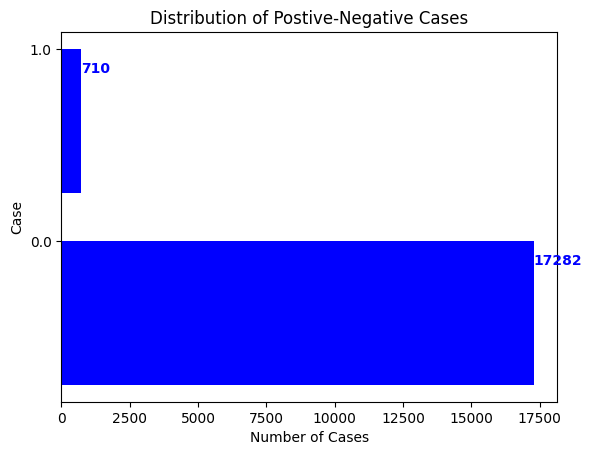

In [67]:
# Simple Bar Graph to visualise distribution of Positive and Negative Cases

label_count = data['f_purchase_lh'].fillna(0).value_counts()

x = list(label_count.index)
y = list(label_count)

fig, ax = plt.subplots()
width = 0.75 # the width of the bars
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(y):
    ax.text(v + .25, i + .25, str(v), color='blue', fontweight='bold') #add value labels into bar

plt.title('Distribution of Postive-Negative Cases')
plt.xlabel('Number of Cases')
plt.ylabel('Case')
plt.show()

The general strategies to fix dataset imbalance can be categorised into two groups: **Sampling methods** and **Cost Sensitive methods**

**Sampling Methods**

*   *Oversampling*: Generates additional data points for the underrepresented class. Helps to reduce the imbalance of classes. Can be automated using Synthetic Minority Oversampling Technique (SMOTE). It is worth noting that adding false data points to a dataset can adversely affect model accuracy by strengthening noise.
  *  The SMOTE algorithm uses euclidean distances (K-NN) to generate synthetic data. Though SMOTE is unable to use its euclidean distance algorithm to generate categorical variables, such as the binary metrics found in the dataset, SMOTE-NC is capable of handling a mix of categorical and continuous features.

*   *Undersampling*: Statistical experts commonly recommend this strategy, but it is only effective when enough instances are available for the reduced class. This method does not involve adding artificial data points, thus avoiding any distortion of the data distribution, but reduces the total number of data points.

**Cost Sensitive Methods**

Cost-sensitive methods are a technique used to make a model more sensitive to the minority class. This is done by adjusting the cost of misclassifying samples into different classes. These methods are very similar to over and undersampling, but the weights are adjusted instead of changing the number of samples to achieve the same result. Can be implemented using `sklearn.utils.class_weight`. The weights can be used with any sklearn classifier as the classification model.

Ideally, a mix of oversampling and undersampling is implemented with the cost sensitive methods to build an [accurate model](https://machinelearningmastery.com/data-sampling-methods-for-imbalanced-classification/).



In [68]:
object_columns = list(data.select_dtypes(include=['object']).columns)
false_columns = list(data.columns[data.columns.str.contains('ape_.*|sumins_.*|prempaid_.*|n_months_last_bought_.*|.*_amt', regex = True)])
categorical_columns = list(set(object_columns) - set(false_columns)) + list(data.select_dtypes(include=['category']).columns) + list(data.columns[data.columns.str.contains('f_.*|flg_', regex = True)])
numerical_columns = list(set(data.columns) - set(categorical_columns))
categorical_columns.remove('f_purchase_lh')

In [69]:
# Oversampling

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale data for oversampling, which uses KNN algorithm
for column in numerical_columns:
  data[column] = StandardScaler().fit_transform(np.array(data[column]).reshape(-1, 1))

X = data.drop(columns = ['f_purchase_lh'])
y = data['f_purchase_lh']

In [70]:
# split into 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

sm = SMOTENC(categorical_features = X_train.columns.get_indexer(categorical_columns),
             random_state = 2, sampling_strategy = 1)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

##  *One-Hot Encoding*

One hot encoding is necessary for categorical columns before processing it further into a model

In [71]:
# One hot encoding is necessary for categorical columns before processing it further into a model
X_train_OHE = X_train

for col in categorical_columns:
    col_ohe = pd.get_dummies(X_train[col], prefix=col)
    X_train_OHE = pd.concat((X_train_OHE, col_ohe), axis=1).drop(col, axis=1)

X_test_OHE = X_test
for col in categorical_columns:
    col_ohe = pd.get_dummies(X_test[col], prefix=col)
    X_test_OHE = pd.concat((X_test_OHE, col_ohe), axis=1).drop(col, axis=1)

In [72]:
# Feature Selection by Filter method
# Information Gain

importances = mutual_info_classif(X_train_OHE.to_numpy(), y_train.to_numpy())
feat_importances = pd.Series(importances, X_train_OHE.columns)

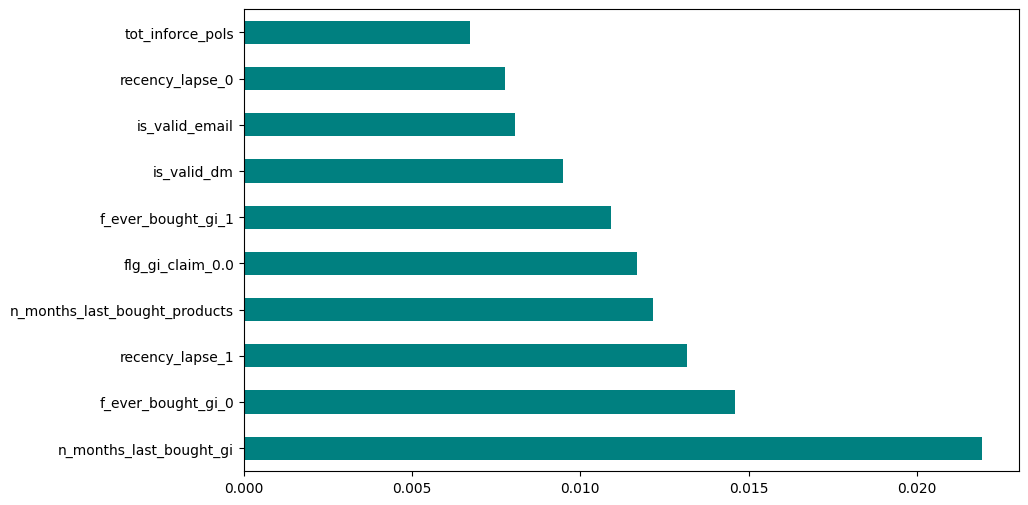

In [73]:
# Select the top 10 features
top_10_feats = feat_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_feats.plot(kind='barh', color='teal')
plt.show()

In [74]:
# We will use these top 10 features to train a CNN Model
top_10 = top_10_feats.index.to_list()
print(top_10)

['n_months_last_bought_gi', 'f_ever_bought_gi_0', 'recency_lapse_1', 'n_months_last_bought_products', 'flg_gi_claim_0.0', 'f_ever_bought_gi_1', 'is_valid_dm', 'is_valid_email', 'recency_lapse_0', 'tot_inforce_pols']


In [75]:
# Selecting Top 10 Features only
X_train_OHE_top_10 = X_train_OHE.loc[:, top_10]
X_test_OHE_top_10 = X_test_OHE.loc[:, top_10]

In [76]:
# Checking shapes to make sure everything fits
X_train_OHE_top_10.shape,X_test_OHE_top_10.shape,y_train.shape,y_test.shape

((12594, 10), (5398, 10), (12594,), (5398,))

##  *Training a Convolutional Neural Network*

After One-Hot Encoding (OHE) and Filtering by IG, We will pass through the data to train a simple 1 hidden layer,2 label CNN Model.

In [77]:
# Set random seed
tf.random.set_seed(0)

# 1. Create the model using the Sequential API
# Input Layer: number of features
# For hidden layer: the number of neurons should be in between the input data dimension and the output data dimension.
# Last layer: number of classes
model = keras.Sequential([layers.Dense(10, activation='relu'),
                          layers.Dense(6, activation='relu'),
                          layers.Dense(1, activation='sigmoid')])

# 2. Compile the model
model.compile(loss="binary_crossentropy",
              optimizer= "adam",
              metrics=["accuracy"])

# 3. Fit the model
model.fit(X_train_OHE_top_10, y_train, epochs=5)

Epoch 1/5
394/394 [==============================] - 2s 2ms/step - loss: 0.4983 - accuracy: 0.7215
Epoch 2/5
394/394 [==============================] - 1s 2ms/step - loss: 0.1492 - accuracy: 0.9597
Epoch 3/5
394/394 [==============================] - 1s 2ms/step - loss: 0.1431 - accuracy: 0.9597
Epoch 4/5
394/394 [==============================] - 1s 2ms/step - loss: 0.1414 - accuracy: 0.9597
Epoch 5/5
394/394 [==============================] - 1s 2ms/step - loss: 0.1409 - accuracy: 0.9597


In [78]:
# Evaluate Model with Test Data
score = model.evaluate(x=X_test_OHE_top_10, y=y_test)
print("Test loss:", score[0])
print("Test Accuracy: ", score[1])

169/169 [==============================] - 0s 1ms/step - loss: 0.1356 - accuracy: 0.9624
Test loss: 0.13555188477039337
Test Accuracy:  0.9623934626579285


# *Some more classification models*

## 1. Decision Tree

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      5195
         1.0       0.15      0.10      0.12       203

    accuracy                           0.94      5398
   macro avg       0.56      0.54      0.55      5398
weighted avg       0.93      0.94      0.94      5398



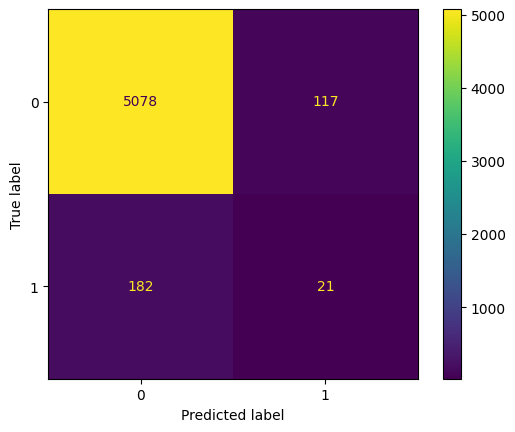

In [79]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=20)
dt_clf.fit(X_train_OHE_top_10, y_train)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate on validation set
y_test_pred = dt_clf.predict(X_test_OHE_top_10)
print(classification_report(y_test, y_test_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot()

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

model = dt_clf
scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5)
f1_scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5, scoring='f1_macro')
scores, f1_scores

(array([0.94918618, 0.94362842, 0.94204049, 0.94918618, 0.94837172]),
 array([0.54909124, 0.5677679 , 0.54759339, 0.54962709, 0.54247297]))

## 2. K-Nearest Neighbours

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      5195
         1.0       0.17      0.07      0.10       203

    accuracy                           0.95      5398
   macro avg       0.57      0.53      0.54      5398
weighted avg       0.93      0.95      0.94      5398



(array([0.95275903, 0.9511711 , 0.94759825, 0.95037713, 0.94956315]),
 array([0.55979711, 0.55736623, 0.55228149, 0.51733309, 0.52353452]))

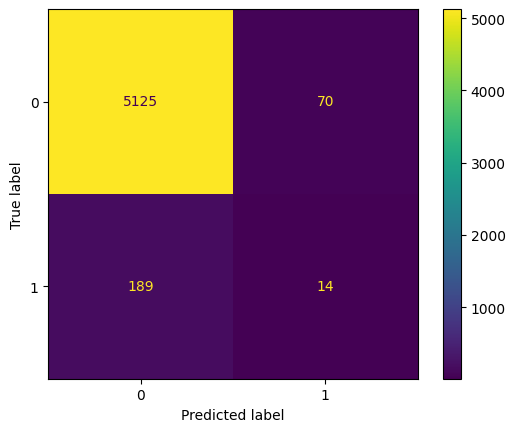

In [81]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_clf.fit(X_train_OHE_top_10, y_train)

# Evaluate on validation set
y_test_pred = knn_clf.predict(X_test_OHE_top_10)
print(classification_report(y_test, y_test_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot()

# Cross validation
model = knn_clf
scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5)
f1_scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5, scoring='f1_macro')
scores, f1_scores

## 3. Random Forest

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      5195
         1.0       0.20      0.08      0.12       203

    accuracy                           0.95      5398
   macro avg       0.58      0.54      0.55      5398
weighted avg       0.94      0.95      0.94      5398



(array([0.95275903, 0.953553  , 0.94918618, 0.9511711 , 0.95552025]),
 array([0.54448463, 0.55414057, 0.54856125, 0.53506237, 0.51937547]))

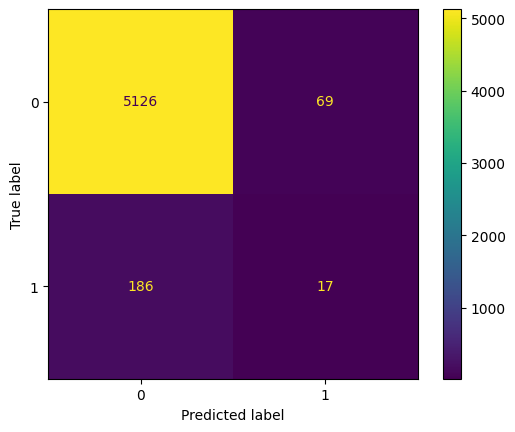

In [82]:
from sklearn.ensemble import RandomForestClassifier
rndforest_clf = RandomForestClassifier(n_estimators=100, max_depth=20)
rndforest_clf.fit(X_train_OHE_top_10, y_train)

# Evaluate on validation set
y_test_pred = rndforest_clf.predict(X_test_OHE_top_10)
print(classification_report(y_test, y_test_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot()

# Cross validation
model = rndforest_clf
scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5)
f1_scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5, scoring='f1_macro')
scores, f1_scores

## 4. Gradient Boosting

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      5195
         1.0       0.40      0.01      0.02       203

    accuracy                           0.96      5398
   macro avg       0.68      0.50      0.50      5398
weighted avg       0.94      0.96      0.94      5398



(array([0.95990472, 0.95950774, 0.95990472, 0.95990472, 0.95869738]),
 array([0.50881044, 0.51743295, 0.55061159, 0.52645176, 0.50796657]))

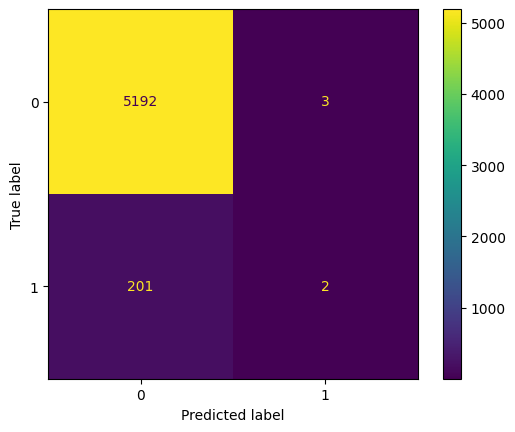

In [83]:
from sklearn.ensemble import GradientBoostingClassifier
boosted_clf = GradientBoostingClassifier(learning_rate=0.1)
boosted_clf.fit(X_train_OHE_top_10, y_train)

# Evaluate on validation set
y_test_pred = boosted_clf.predict(X_test_OHE_top_10)
print(classification_report(y_test, y_test_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot()

# Cross validation
model = boosted_clf
scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5)
f1_scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5, scoring='f1_macro')
scores, f1_scores

## 5. Support Vector Machine

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      5195
         1.0       0.21      0.30      0.25       203

    accuracy                           0.93      5398
   macro avg       0.59      0.63      0.61      5398
weighted avg       0.94      0.93      0.94      5398



(array([0.93608575, 0.94164351, 0.93926161, 0.9372767 , 0.93963463]),
 array([0.63173217, 0.64913143, 0.64106282, 0.62122464, 0.61887388]))

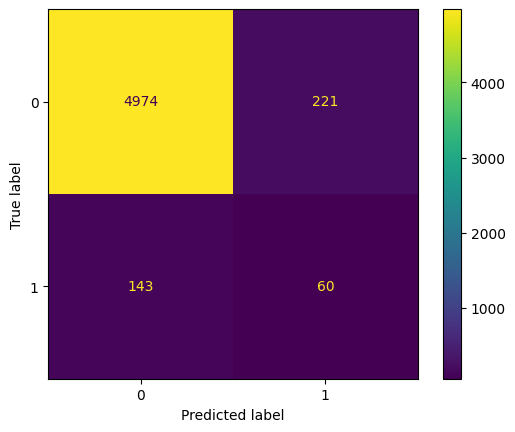

In [84]:
from sklearn.svm import SVC

svm_clf = SVC(C=1, kernel='rbf', gamma='auto', class_weight={1:4, 0:1})
svm_clf.fit(X_train_OHE_top_10, y_train)

# Evaluate on validation set
y_test_pred = svm_clf.predict(X_test_OHE_top_10)
print(classification_report(y_test, y_test_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot()

# Cross validation
model = svm_clf
scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5)
f1_scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5, scoring='f1_macro')
scores, f1_scores

## 6. Logistic Regression

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      5195
         1.0       0.27      0.26      0.26       203

    accuracy                           0.95      5398
   macro avg       0.62      0.61      0.62      5398
weighted avg       0.94      0.95      0.95      5398



(array([0.94720127, 0.94998015, 0.94958317, 0.9464073 , 0.94956315]),
 array([0.6452432 , 0.655426  , 0.62817978, 0.59139424, 0.60211518]))

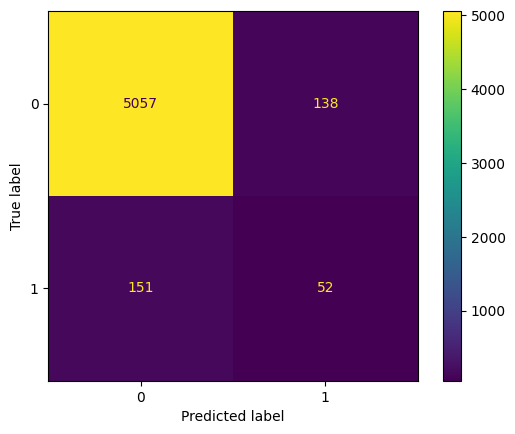

In [85]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(C=0.01, penalty='l2', class_weight={1:4, 0:1})
log_clf.fit(X_train_OHE_top_10, y_train)

# Evaluate on validation set
y_test_pred = log_clf.predict(X_test_OHE_top_10)
print(classification_report(y_test, y_test_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot()

# Cross validation
model = log_clf
scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5)
f1_scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5, scoring='f1_macro')
scores, f1_scores

## 7. Neural Networks

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      5195
         1.0       0.00      0.00      0.00       203

    accuracy                           0.96      5398
   macro avg       0.48      0.50      0.49      5398
weighted avg       0.93      0.96      0.94      5398



(array([0.95990472, 0.95990472, 0.95950774, 0.95950774, 0.9598888 ]),
 array([0.48977112, 0.48977112, 0.48966775, 0.48966775, 0.48976697]))

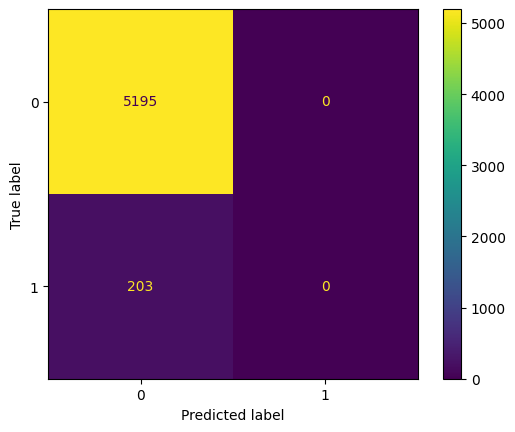

In [86]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier(alpha=1e-2, random_state=0)
nn_clf.fit(X_train_OHE_top_10, y_train)

# Evaluate on validation set
y_test_pred = nn_clf.predict(X_test_OHE_top_10)
print(classification_report(y_test, y_test_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot()

# Cross validation
model = nn_clf
scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5)
f1_scores = cross_val_score(model, X_train_OHE_top_10, y_train, cv=5, scoring='f1_macro')
scores, f1_scores

# Final Model: Support Vector Machine

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     12087
         1.0       0.28      0.33      0.30       507

    accuracy                           0.94     12594
   macro avg       0.63      0.65      0.64     12594
weighted avg       0.94      0.94      0.94     12594

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      5195
         1.0       0.21      0.30      0.25       203

    accuracy                           0.93      5398
   macro avg       0.59      0.63      0.61      5398
weighted avg       0.94      0.93      0.94      5398



(array([0.93608575, 0.94164351, 0.93926161, 0.9372767 , 0.93963463]),
 array([0.63173217, 0.64913143, 0.64106282, 0.62122464, 0.61887388]))

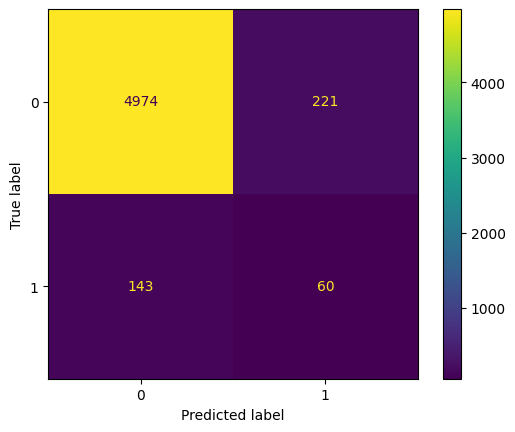

In [87]:
final_model = svm_clf

# Evaluate on training set
y_train_pred = final_model.predict(X_train_OHE_top_10)
print(classification_report(y_train, y_train_pred))

# Evaluate on validation set
y_test_pred = final_model.predict(X_test_OHE_top_10)
print(classification_report(y_test, y_test_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # set display_label according to dataset
disp.plot()

scores = cross_val_score(final_model, X_train_OHE_top_10, y_train, cv=5)
f1_scores = cross_val_score(final_model, X_train_OHE_top_10, y_train, cv=5, scoring='f1_macro')
scores, f1_scores

# **Conclusion**

Considering good performances on various models (about 95% accuracy), we can conclude that the models are generally capable of predicting the willingness of customers buying insurance products.

Out of all the models we tried, we decided to choose the SVM model since the 5-fold cross validation produced the best f1 macro scores of about 65% while having similar accuracy score (about 94%) compared to the rest of the models.

To draw further insights from those models, we take a look at the corresponding input variables. The variables that we select are the top 10 variables with largest infomation gains and they offer decent performances in the model, we can pay more attention to those factors and think about how to achieve better effect on improving the values of those factors.

For example, 'is_valid_email', 'is_valid_dm', are whether customers have indicated valid email and direct mail addresses, and valid indications are more likely to send the promotion over to customers and hence increase the chance of buying more products in the future. Hence, a corresponding strategy would be a rewarding system that rewards customers of putting in valid addresses.

Morevoer, several other variables, like 'n_months_last_bought_gi', 'f_ever_bought_gi_0', 'recency_lapse_1', 'f_ever_bought_gi_1', 'n_months_last_bought_products', suggest that there may be a possible link between purchasing history and the willingness to purchase. Therefore, it is practically beneficial to further study the past behaviours of customers, like different types of products and duration of buying products, and send personalised promotion plans to customers with different purchasing behaviours.


Finally, some more possibilities can arise since we discarded some columns for simplication and accuracy purposes, but there might be insightful causations among those variables as well.

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [88]:
import pandas as pd
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform.

All relevant code MUST be included in this function.'''
    hidden_data = hidden_data.drop(columns = ['giclaim_cnt_success',
                                              'recency_giclaim_success',
                                              'giclaim_cnt_unsuccess',
                                              'recency_giclaim_unsuccess',
                                              'flg_gi_claim_29d435_ever',
                                              'flg_gi_claim_058815_ever',
                                              'flg_gi_claim_42e115_ever',
                                              'flg_gi_claim_856320_ever'])
    hidden_data = hidden_data[hidden_data.columns.drop(list(hidden_data.filter(regex = 'lapse_ape_.*|n_months_since_lapse_.*')))]

    na_hidden_data = hidden_data[hidden_data.columns[hidden_data.isnull().any()]]
    for column in na_hidden_data.columns[na_hidden_data.columns.str.contains('flg_.*|is_.*|f_.*', regex = True)].tolist():
        hidden_data[column] = hidden_data[column].fillna(value = 0)

    for column in na_hidden_data.columns[na_hidden_data.columns.str.contains('recency_.*|n_months_since_visit_affcon', regex = True)].tolist():
        hidden_data[column] = pd.cut(x = hidden_data[column],
                                     bins = globalbin[column],
                                     labels = list(range(1,len(set(globalbin[column])))),
                                     duplicates = 'drop')

    # Fill missing values with 0 (categorical)
    for column in na_hidden_data.columns[na_hidden_data.columns.str.contains('recency_.*|n_months_since_visit_affcon', regex = True)].tolist():
        hidden_data[column] = hidden_data[column].cat.add_categories(0).fillna(0)

    # Drop unwanted columns
    hidden_data = hidden_data.drop(columns = ['clntnum', 'hh_20', 'pop_20', 'hh_size'])

    # Fill missing data for description columns
    hidden_data['race_desc'] = hidden_data['race_desc'].fillna('Unknown')
    hidden_data['ctrycode_desc'] = hidden_data['ctrycode_desc'].fillna('Unknown')
    hidden_data['cltsex_fix'] = hidden_data['cltsex_fix'].fillna('Unknown')
    hidden_data['hh_size_est'] = hidden_data['hh_size_est'].fillna('Unknown')
    hidden_data['annual_income_est'] = hidden_data['annual_income_est'].fillna('Unknown')

    # Fill remaining missing values
    hidden_data = hidden_data.fillna(0)

    # Convert appropriate columns to datetime format
    hidden_data['min_occ_date'] = pd.to_datetime(hidden_data['min_occ_date'],
                                          format = '%Y-%m-%d',
                                          errors='coerce')
    hidden_data['cltdob_fix'] = pd.to_datetime(hidden_data['cltdob_fix'],
                                        format = '%Y-%m-%d',
                                        errors='coerce')

    object_columns = list(hidden_data.select_dtypes(include=['object']).columns)
    false_columns = list(hidden_data.columns[hidden_data.columns.str.contains('ape_.*|sumins_.*|prempaid_.*|n_months_last_bought_.*|.*_amt', regex = True)])
    categorical_columns = list(set(object_columns) - set(false_columns)) + list(hidden_data.select_dtypes(include=['category']).columns) + list(hidden_data.columns[hidden_data.columns.str.contains('f_.*|flg_', regex = True)])
    numerical_columns = list(set(hidden_data.columns) - set(categorical_columns))

    # Scale data for oversampling, which uses KNN algorithm
    for column in numerical_columns:
        hidden_data[column] = StandardScaler().fit_transform(np.array(hidden_data[column]).reshape(-1, 1))

    # One hot encoding is necessary for categorical columns before processing it further into a model
    hidden_data_OHE = hidden_data
    for col in categorical_columns:
        hidden_col_ohe = pd.get_dummies(hidden_data[col], prefix=col)
        hidden_data_OHE = pd.concat((hidden_data_OHE, hidden_col_ohe), axis=1).drop(col, axis=1)

    # Evaluate on validation set
    hidden_data_OHE_top_10 = hidden_data_OHE.loc[:, top_10]
    pred = final_model.predict(hidden_data_OHE_top_10)

    result = pred

    return pred

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))